In [12]:
!pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.1 MB/s eta 0:00:00


In [18]:
!pip install tensorflow

In [1]:
# imports & seeds
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# reproducibility seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [2]:
# parameters (FILE_PATH set to the uploaded Excel file)
FILE_PATH = "mental_health_sentiment_dataset.csv"   # <- your uploaded file
MAX_WORDS = 100            # max tokens per entry (truncate/pad)
MAX_SEQ_LEN = 8            # number of previous entries (timesteps)
VOCAB_SIZE = 10000         # tokenizer vocab size (can lower to speed up)
EMBEDDING_DIM = 128
ENTRY_LSTM_UNITS = 64
SEQ_LSTM_UNITS = 64
BATCH_SIZE = 64
EPOCHS = 6                 # increase if you have time/GPU
TEST_USER_SPLIT = (0.8, 0.1, 0.1)  # train/val/test split by user
MODEL_SAVE_PATH = "lstm_seq_model.h5"
TOKENIZER_SAVE = "tokenizer.json"

In [3]:
# load dataset automatically depending on file type
if FILE_PATH.endswith(".csv"):
    df = pd.read_csv(FILE_PATH)
elif FILE_PATH.endswith((".xls", ".xlsx")):
    df = pd.read_excel(FILE_PATH, engine="openpyxl")
else:
    raise ValueError("Unsupported file format. Please use CSV, XLS, or XLSX.")

# detect label column
if 'sentiment_label' in df.columns:
    label_col = 'sentiment_label'
elif 'sentiment' in df.columns:
    label_col = 'sentiment'
elif 'emotion_label' in df.columns:
    label_col = 'emotion_label'
else:
    raise ValueError("No sentiment column found. Expected one of 'sentiment_label','sentiment','emotion_label'.")

# parse timestamps
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
elif 'date' in df.columns:
    df['timestamp'] = pd.to_datetime(df['date']) + pd.to_timedelta(np.random.randint(0, 24*3600, size=len(df)), unit='s')
else:
    raise ValueError("No timestamp/date column found. Expected 'timestamp' or 'date'.")

print("Loaded rows:", len(df))
print("Columns:", list(df.columns))
print("Label column used:", label_col)
print("\nLabel distribution:\n", df[label_col].value_counts())
if 'session_type' in df.columns:
    print("\nSession type distribution:\n", df['session_type'].value_counts())

Loaded rows: 15000
Columns: ['id', 'date', 'session_type', 'duration_minutes', 'word_count', 'sentiment', 'emotion_label', 'text', 'timestamp']
Label column used: sentiment

Label distribution:
 sentiment
positive    5092
neutral     4954
negative    4954
Name: count, dtype: int64

Session type distribution:
 session_type
chat       7584
journal    7416
Name: count, dtype: int64


In [20]:
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# download stopwords if not already
nltk.download("stopwords")
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("english"))

# ----- Text cleaning function -----
def clean_text(text):
    text = str(text).lower()                      # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove links
    text = re.sub(r"[^a-z\s]", '', text)          # keep only alphabets
    text = " ".join([w for w in text.split() if w not in STOPWORDS])  # remove stopwords
    return text

# Apply cleaning
df["clean_text"] = df["text"].apply(clean_text)  # assuming column name is 'text'

# ----- Tokenization -----
MAX_WORDS = 10000   # vocabulary size
MAX_LEN = 100       # max sequence length

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

X = tokenizer.texts_to_sequences(df["clean_text"])
X = pad_sequences(X, maxlen=MAX_LEN, padding="post", truncating="post")

# ----- Encode labels -----
le = LabelEncoder()
y = le.fit_transform(df[label_col])

print("Vocabulary size:", len(tokenizer.word_index))
print("Sample sequence:", X[0])
print("Encoded label sample:", y[0])
print("Unique labels:", le.classes_)

  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 1.0/331.9 MB 4.6 MB/s eta 0:01:13
   ---------------------------------------- 2.4/331.9 MB 5.0 MB/s eta 0:01:07
   ---------------------------------------- 3.4/331.9 MB 5.2 MB/s eta 0:01:04
    --------------------------------------- 5.0/331.9 MB 5.6 MB/s eta 0:00:59
    --------------------------------------- 6.6/331.9 MB 5.9 MB/s eta 0:00:55
    --------------------------------------- 7.9/331.9 MB 6.1 MB/s eta 0:00:54
   - -------------------------------------- 9.4/331.9 MB 6.2 MB/s eta 0:00:53
   - -------------------------------------- 10.5/331.9 MB 6.2 MB/s eta 0:00:53
   - -------------------------------------- 12.1/331.9 MB 6.3 MB/s eta 0:00:51
   - -------------------------------------- 13.6/331.9 MB 6.4 MB/s eta 0:00:50
   - ----

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Vocabulary size: 54
Sample sequence: [27 49 50 51  5  6  7  8 18 19 20 12 13 14  9 10  2 11  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
Encoded label sample: 1
Unique labels: ['negative' 'neutral' 'positive']


In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# One-hot encode labels for categorical classification
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print("Training data shape:", X_train.shape, y_train_cat.shape)
print("Testing data shape:", X_test.shape, y_test_cat.shape)
print("Number of classes:", num_classes)
print("Classes:", le.classes_)

Training data shape: (12000, 100) (12000, 3)
Testing data shape: (3000, 100) (3000, 3)
Number of classes: 3
Classes: ['negative' 'neutral' 'positive']


In [30]:
# build LSTM model (uses MAX_WORDS and MAX_LEN as defined earlier in Cell 4)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

embedding_dim = 128
lstm_units = 128

model = Sequential([
    Embedding(input_dim=MAX_WORDS,       # <- was max_words (undefined)
              output_dim=embedding_dim,
              input_length=MAX_LEN),     # <- was maxlen (undefined)
    LSTM(lstm_units, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

model.summary()

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
# training with callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_lstm_model.h5", monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# If you reserved X_test as the test set, use validation_split on the training set:
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.1,   # use 10% of train as validation
    epochs=10,              # increase if you have time/GPU
    batch_size=64,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/10

Epoch 1: val_loss improved from None to 1.09904, saving model to best_lstm_model.h5


169/169 - 63s - 372ms/step - accuracy: 0.3358 - loss: 1.0999 - val_accuracy: 0.3108 - val_loss: 1.0990 - learning_rate: 1.0000e-03
Epoch 2/10

Epoch 2: val_loss improved from 1.09904 to 1.09837, saving model to best_lstm_model.h5


169/169 - 53s - 315ms/step - accuracy: 0.3360 - loss: 1.0993 - val_accuracy: 0.3508 - val_loss: 1.0984 - learning_rate: 1.0000e-03
Epoch 3/10

Epoch 3: val_loss did not improve from 1.09837
169/169 - 52s - 305ms/step - accuracy: 0.3324 - loss: 1.0995 - val_accuracy: 0.3108 - val_loss: 1.0995 - learning_rate: 1.0000e-03
Epoch 4/10

Epoch 4: val_loss did not improve from 1.09837

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 - 82s - 488ms/step - accuracy: 0.3357 - loss: 1.0991 - val_accuracy: 0.3383 - val_loss: 1.0985 - learning_rate: 1.0000e-03
Epoch 5/10

Epoch 5: val_loss did not improve from 1.09837
169/169 - 83s - 490ms/step - accuracy: 0.3369 - loss: 1.0988 - val_accuracy: 0.3108 - val_loss: 1.0992 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


94/94 - 7s - 75ms/step - accuracy: 0.3303 - loss: 1.0988
Test loss: 1.0988, Test acc: 0.3303
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step
Classification report (test):
              precision    recall  f1-score   support

    negative      0.000     0.000     0.000       991
     neutral      0.330     1.000     0.497       991
    positive      0.000     0.000     0.000      1018

    accuracy                          0.330      3000
   macro avg      0.110     0.333     0.166      3000
weighted avg      0.109     0.330     0.164      3000



C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


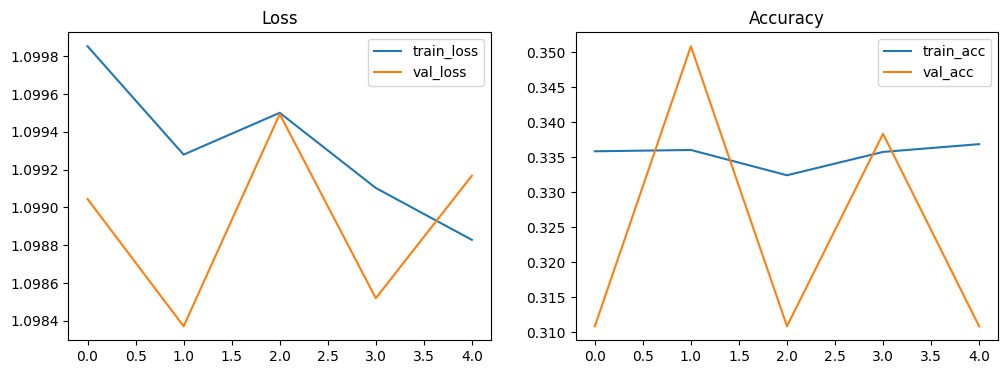

In [32]:
# evaluate and diagnostics
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as skm

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=2)
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Predictions and classification report
y_pred_probs = model.predict(X_test, batch_size=64)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification report (test):")
print(skm.classification_report(y_test, y_pred, target_names=le.classes_, digits=3))

# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [36]:
# test prediction on new samples

def predict_sentiment(texts):
    # clean and preprocess
    seqs = tokenizer.texts_to_sequences(texts)
    seqs_pad = pad_sequences(seqs, maxlen=MAX_LEN)
    # predict
    probs = model.predict(seqs_pad)
    preds = np.argmax(probs, axis=1)
    labels = le.inverse_transform(preds)
    return list(zip(texts, labels, probs.max(axis=1)))

# Example usage
new_entries = [
    "I feel so low today. Nothing excites me anymore, and I just want to stay in bed.",
    "I had such a great day with my friends! Laughing together really lifted my mood.",
    "My mind won’t stop racing. I keep worrying about my future and my job.",
    "I'm frustrated. Nothing seems to go my way lately.",
    "It’s just a normal day, nothing special."
]

predictions = predict_sentiment(new_entries)
for text, label, confidence in predictions:
    print(f"\nText: {text}\nPredicted Sentiment: {label} (conf={confidence:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

Text: I feel so low today. Nothing excites me anymore, and I just want to stay in bed.
Predicted Sentiment: negative (conf=0.34)

Text: I had such a great day with my friends! Laughing together really lifted my mood.
Predicted Sentiment: negative (conf=0.34)

Text: My mind won’t stop racing. I keep worrying about my future and my job.
Predicted Sentiment: negative (conf=0.34)

Text: I'm frustrated. Nothing seems to go my way lately.
Predicted Sentiment: negative (conf=0.34)

Text: It’s just a normal day, nothing special.
Predicted Sentiment: negative (conf=0.34)


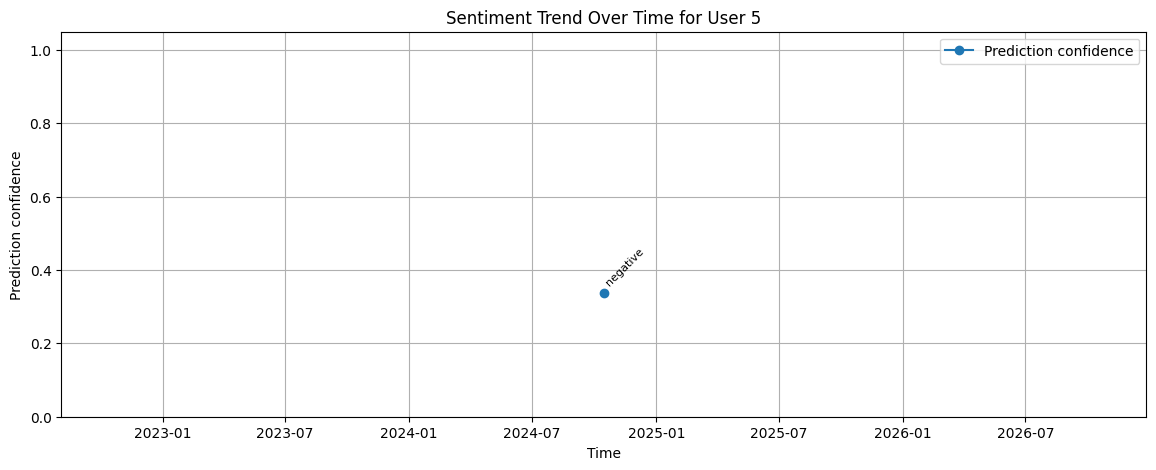

,timestamp,text,pred_label,pred_score
4,2024-10-15 01:44:25,[HAPPY] I’m proud of myself Sometimes I wonder...,negative,0.33687


In [52]:
# visualize sentiment trend for a given user

import matplotlib.pyplot as plt

def plot_user_sentiment_trend(id, n_entries=50):
    # filter user data
    user_df = df[df["id"] == id].sort_values("timestamp").copy()

    if len(user_df) == 0:
        print("No entries found for user:", user_id)
        return
    
    # preprocess texts
    seqs = tokenizer.texts_to_sequences(user_df["clean_text"].tolist())
    seqs_pad = pad_sequences(seqs, maxlen=MAX_LEN)
    
    # model predictions
    probs = model.predict(seqs_pad, verbose=0)
    preds = np.argmax(probs, axis=1)
    labels = le.inverse_transform(preds)
    
    # add predictions to dataframe
    user_df["pred_label"] = labels
    user_df["pred_score"] = probs.max(axis=1)
    
    # take a subset for readability
    if len(user_df) > n_entries:
        user_df = user_df.head(n_entries)
    
    # plot
    plt.figure(figsize=(14,5))
    plt.plot(user_df["timestamp"], user_df["pred_score"], marker="o", label="Prediction confidence")
    
    for i, row in user_df.iterrows():
        plt.text(row["timestamp"], row["pred_score"]+0.02, row["pred_label"], rotation=45, fontsize=8)
    
    plt.title(f"Sentiment Trend Over Time for User {id}")
    plt.xlabel("Time")
    plt.ylabel("Prediction confidence")
    plt.ylim(0,1.05)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return user_df[["timestamp", "text", "pred_label", "pred_score"]]

# ✅ call the function with correct name
trend_df = plot_user_sentiment_trend(id=5, n_entries=40)
trend_df.head()

In [54]:
import pickle

# Save the trained model
model.save("lstm_sentiment_model.h5")

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ Model, tokenizer, and label encoder saved successfully!")

✅ Model, tokenizer, and label encoder saved successfully!


In [56]:
from tensorflow.keras.models import load_model

# Reload model
loaded_model = load_model("lstm_sentiment_model.h5")

# Reload tokenizer
with open("tokenizer.pkl", "rb") as f:
    loaded_tokenizer = pickle.load(f)

# Reload label encoder
with open("label_encoder.pkl", "rb") as f:
    loaded_le = pickle.load(f)

print("✅ Model and preprocessing tools reloaded!")

# Test reload on a new text
test_text = ["I feel very anxious about tomorrow."]
seqs = loaded_tokenizer.texts_to_sequences(test_text)
seqs_pad = pad_sequences(seqs, maxlen=MAX_LEN)
probs = loaded_model.predict(seqs_pad)
pred = np.argmax(probs, axis=1)
print("Predicted sentiment:", loaded_le.inverse_transform(pred)[0])

✅ Model and preprocessing tools reloaded!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Predicted sentiment: negative
